# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

Text(0.5, 1.0, 'image label: 3')

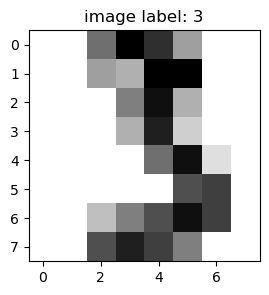

In [84]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index])

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [85]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [86]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [87]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [88]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [89]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [90]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [91]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [92]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [93]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [94]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [95]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [96]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [97]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [98]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b
        
        # Return the softmax of the linear combination
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b

In [99]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

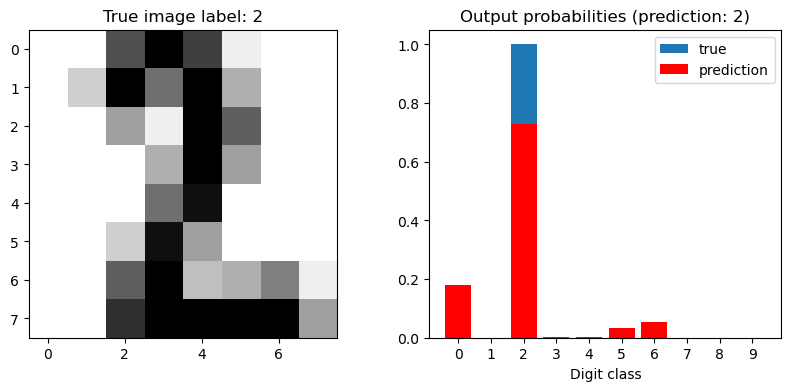

In [100]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [101]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 215
Average NLL over the last 100 samples at step 200: 85
Average NLL over the last 100 samples at step 300: 446
Average NLL over the last 100 samples at step 400: 37
Average NLL over the last 100 samples at step 500: 161
Average NLL over the last 100 samples at step 600: 113
Average NLL over the last 100 samples at step 700: 65
Average NLL over the last 100 samples at step 800: 77
Average NLL over the last 100 samples at step 900: 54
Average NLL over the last 100 samples at step 1000: 415
Average NLL over the last 100 samples at step 1100: 109
Average NLL over the last 100 samples at step 1200: 92
Average NLL over the last 100 samples at step 1300: 189
Average NLL over the last 100 samples at step 1400: 94
Average NLL over the last 100 samples at step 1500: 148


Evaluate the trained model on the first example:

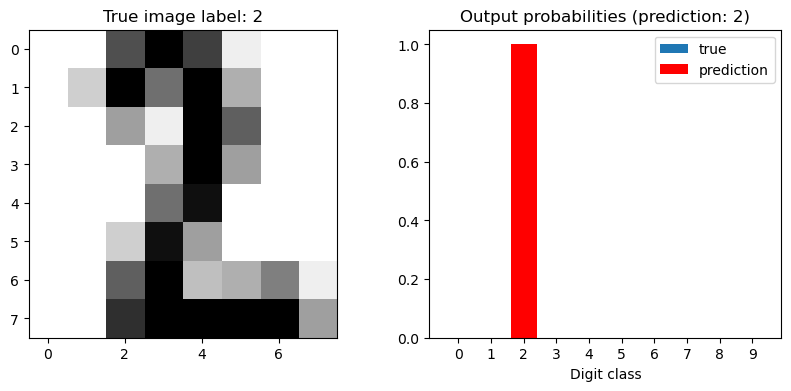

In [102]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

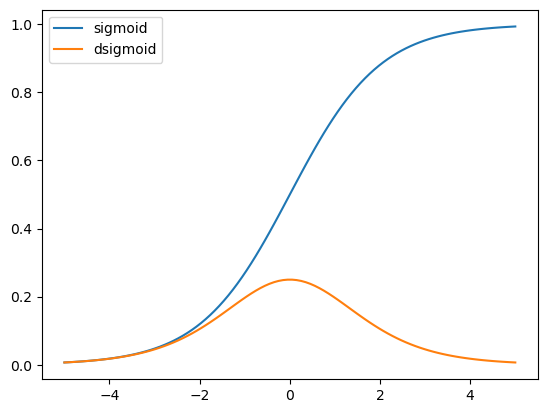

In [103]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow,  value to be in certain range
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow.  This is the range
    return 1 / (1+ np.exp(-X))


def dsigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [104]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [105]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [106]:
model.loss(X_train, y_train)

1045.596334268618

In [107]:
model.accuracy(X_train, y_train)

0.12639161755075312

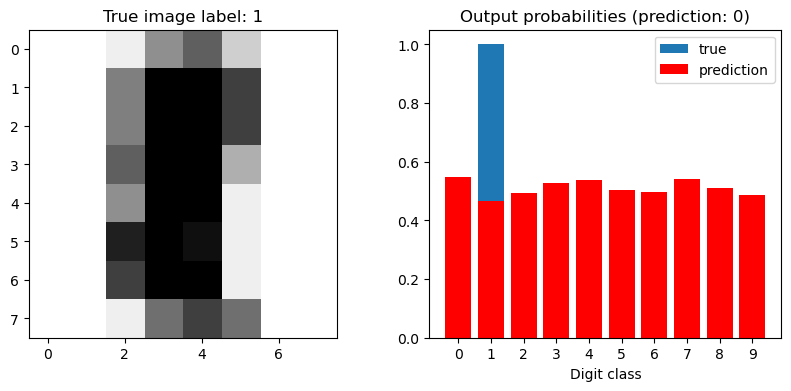

In [108]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [109]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 1045.59633, train acc: 0.126, test acc: 0.115
Epoch #1, train loss: 3444.53811, train acc: 0.105, test acc: 0.096
Epoch #2, train loss: 2986.56122, train acc: 0.359, test acc: 0.322
Epoch #3, train loss: 2588.55107, train acc: 0.460, test acc: 0.441
Epoch #4, train loss: 2328.02621, train acc: 0.635, test acc: 0.626
Epoch #5, train loss: 1872.01492, train acc: 0.743, test acc: 0.737
Epoch #6, train loss: 1616.00787, train acc: 0.789, test acc: 0.785
Epoch #7, train loss: 1344.75568, train acc: 0.789, test acc: 0.781
Epoch #8, train loss: 1201.56264, train acc: 0.776, test acc: 0.774
Epoch #9, train loss: 1114.82518, train acc: 0.800, test acc: 0.785
Epoch #10, train loss: 1013.27188, train acc: 0.801, test acc: 0.789
Epoch #11, train loss: 956.11585, train acc: 0.815, test acc: 0.819
Epoch #12, train loss: 961.27932, train acc: 0.840, test acc: 0.837
Epoch #13, train loss: 890.05808, train acc: 0.849, test acc: 0.863
Epoch #14, train loss: 768.12709, train acc:

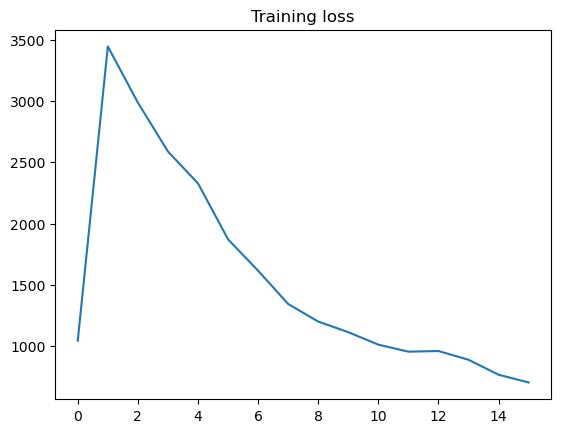

In [110]:
plt.plot(losses)
plt.title("Training loss");

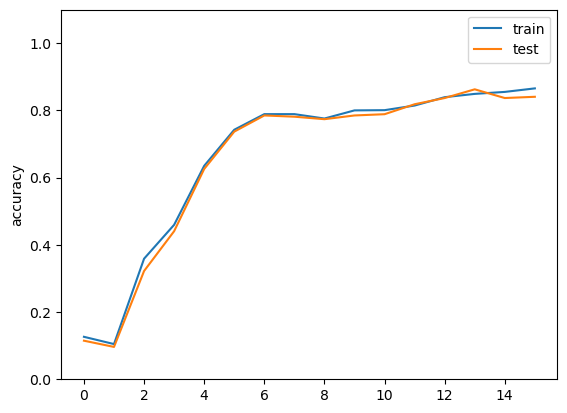

In [111]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best')

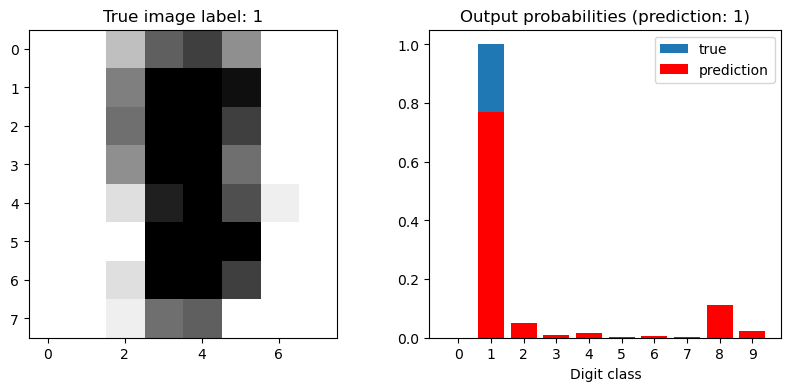

In [112]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [113]:
import numpy as np

# Get the model's predictions on the test set
y_pred_probs = model.forward(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the absolute differences between predicted probabilities and one-hot encoded true labels
y_true_onehot = one_hot(model.output_size, y_test)
prediction_errors = np.abs(y_pred_probs - y_true_onehot).sum(axis=1)

# Find the indices of the samples with the highest prediction errors
worst_predictions_indices = np.argsort(prediction_errors)[-5:]  # Display top 5 worst predictions


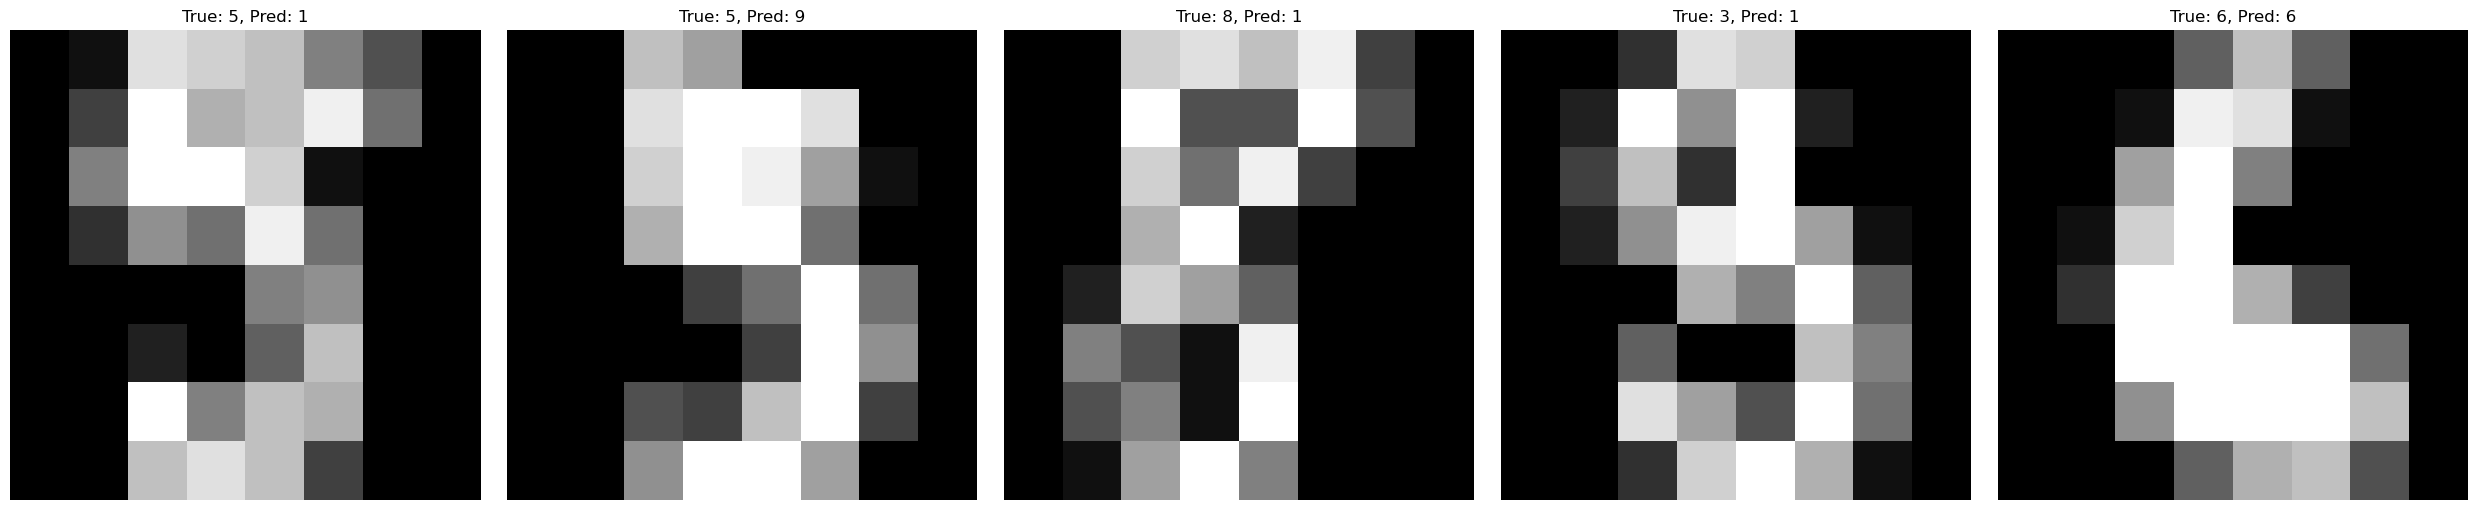

In [114]:
import matplotlib.pyplot as plt

def plot_predictions_in_row(images, true_labels, predicted_labels, ncols=5):
    """Plot multiple images in a single row."""
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(ncols * n_images, ncols))

    if n_images == 1:
        axes = [axes]

    for ax, image_flat, y_true, y_pred in zip(axes, images, true_labels, predicted_labels):
        image_reshaped = image_flat.reshape(8, 8) 
        ax.imshow(image_reshaped, cmap="gray")
        ax.set_title(f"True: {y_true}, Pred: {y_pred}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Plot the worst prediction errors in a single row
n_errors_to_display = 5  # Or any number you want to display
indices_to_plot = worst_predictions_indices[:n_errors_to_display]
images_to_plot = [X_test[idx] for idx in indices_to_plot]
true_labels_to_plot = [y_test[idx] for idx in indices_to_plot]
predicted_labels_to_plot = [y_pred[idx] for idx in indices_to_plot]

plot_predictions_in_row(images_to_plot, true_labels_to_plot, predicted_labels_to_plot, ncols=n_errors_to_display)


```The human eye can often easily identify individual handwritten digits; however, neural networks can discern patterns and anomalies in the data that might not be immediately obvious to humans. Here are a few pointers to consider:```

1. Human Limitations: With a large dataset like MNIST, humans can answer correctly on simpler digits but may struggle with more ambiguous cases (e.g., a digit '1' that looks like a '7').
2. Model's Strength: The neural network can consistently apply its learned parameters to each digit and is not prone to fatigue or subjective bias, unlike a human classifier.```

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [115]:
# Your code here
## extend the NeuralNet class to include support for a second hidden layer:
class NeuralNet:
    """MLP with up to 2 hidden layers with a sigmoid activation"""

    def __init__(self, input_size, hidden_size_1, output_size, hidden_size_2=None):
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size_1), high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size_1, high=0.1, low=-0.1)

        if hidden_size_2:
            self.W_h2 = np.random.uniform(size=(hidden_size_1, hidden_size_2), high=0.1, low=-0.1)
            self.b_h2 = np.random.uniform(size=hidden_size_2, high=0.1, low=-0.1)
            self.W_o = np.random.uniform(size=(hidden_size_2, output_size), high=0.1, low=-0.1)
        else:
            self.W_o = np.random.uniform(size=(hidden_size_1, output_size), high=0.1, low=-0.1)

        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)

        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size

    def forward_hidden_1(self, X):
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        return sigmoid(self.Z_h1)

    def forward_hidden_2(self, H1):
        if self.hidden_size_2:
            self.Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
            return sigmoid(self.Z_h2)
        return H1

    def forward_output(self, H):
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        return sigmoid(self.Z_o)

    def forward(self, X):
        H1 = self.forward_hidden_1(X)
        H2 = self.forward_hidden_2(H1)
        Y = self.forward_output(H2)
        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        error_o = y_pred - y_true
        grad_W_o = np.dot(self.Z_h2.T if self.hidden_size_2 else self.Z_h1.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        if self.hidden_size_2:
            error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
            grad_W_h2 = np.dot(self.Z_h1.T, error_h2)
            grad_b_h2 = np.sum(error_h2, axis=0)
            error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        else:
            error_h1 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h1)

        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        gradients = {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_o": grad_W_o, "b_o": grad_b_o}
        if self.hidden_size_2:
            gradients.update({"W_h2": grad_W_h2, "b_h2": grad_b_h2})

        return gradients

    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]

        if self.hidden_size_2:
            self.W_h2 -= learning_rate * grads["W_h2"]
            self.b_h2 -= learning_rate * grads["b_h2"]

        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)



In [116]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

# Hyperparameters to experiment with
learning_rates = [0.1, 0.01, 0.001]
hidden_sizes_1 = [32, 64, 128]
hidden_sizes_2 = [None, 32, 64]

best_acc = 0
best_params = {}

for lr in learning_rates:
    for h1 in hidden_sizes_1:
        for h2 in hidden_sizes_2:
            model = NeuralNet(input_size=n_features, hidden_size_1=h1, hidden_size_2=h2, output_size=n_classes)

            # Training loop
            for epoch in range(15):
                for i, (x, y) in enumerate(zip(X_train, y_train)):
                    model.train(x, y, learning_rate=lr)

            train_loss = model.loss(X_train, y_train)
            train_acc = model.accuracy(X_train, y_train)
            test_acc = model.accuracy(X_test, y_test)

            print(f"Params: lr={lr}, h1={h1}, h2={h2}, train_loss={train_loss:.5f}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

            if test_acc > best_acc:
                best_acc = test_acc
                best_params = {"learning_rate": lr, "hidden_size_1": h1, "hidden_size_2": h2}

print(f"Best test accuracy: {best_acc:.3f} with params: {best_params}")


Params: lr=0.1, h1=32, h2=None, train_loss=44823.61138, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=32, h2=32, train_loss=34218.63959, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=32, h2=64, train_loss=33242.47432, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=64, h2=None, train_loss=47456.27877, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=64, h2=32, train_loss=47456.27877, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=64, h2=64, train_loss=47456.27877, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=128, h2=None, train_loss=47456.27877, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=128, h2=32, train_loss=23693.46333, train_acc=0.100, test_acc=0.107
Params: lr=0.1, h1=128, h2=64, train_loss=46191.79709, train_acc=0.100, test_acc=0.107
Params: lr=0.01, h1=32, h2=None, train_loss=26873.27687, train_acc=0.100, test_acc=0.107
Params: lr=0.01, h1=32, h2=32, train_loss=4666.56917, train_acc=0.100, test_acc=0.107
Params: lr=0.01, h1=32, h2=64, train_loss=